## Model metrics

In [8]:
from tensorboard_reducer.event_loader import EventAccumulator
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from glob import glob

In [11]:
LOG_PATH = "lightning_logs/"

input_event_dirs = sorted(glob(LOG_PATH+'*'))

joined_dirs = "\n".join(input_event_dirs)
print(f"Found {len(input_event_dirs)} runs:\n{joined_dirs}")

Found 8 runs:
lightning_logs/g_lenet_best_subset
lightning_logs/g_resnet_18_best_subset
lightning_logs/g_resnet_18_cut_dataset
lightning_logs/lenet_best_subset
lightning_logs/resnet_18_best_subset
lightning_logs/resnet_18_cut_dataset
lightning_logs/resnet_18_local_subset
lightning_logs/resnet_50_best_subset


In [25]:
def get_metrics(model_folder):
    accumulator = EventAccumulator(model_folder).Reload()
    load_dict = defaultdict(list)
    for tag in accumulator.scalar_tags:
        df_scalar = pd.DataFrame(accumulator.Scalars(tag)).set_index("step")
        df_scalar = df_scalar.drop(columns="wall_time")
        load_dict[tag].append(df_scalar)

    log_data = {
        key: pd.concat(lst, join="inner", axis=1) for key, lst in load_dict.items()
    }
    epochs = log_data['epoch'].values
    train_loss_epoch = log_data['train_loss_epoch'].values
    train_acc_epoch = log_data['train_acc_epoch'].values
    val_loss = log_data['val_loss'].values
    val_acc = log_data['val_acc'].values
    steps = log_data['val_acc'].index

    return [steps,epochs, train_loss_epoch,train_acc_epoch,val_loss,val_acc]

def plot_metrics(model_folder,show=False):
    run_name = model_folder.split("/")[1]
    steps, epochs, train_loss,train_acc,val_loss,val_acc = get_metrics(model_folder)
    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(221) 
    ax1.plot(steps,train_loss,linestyle='-', c='orange')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Train Loss')

    ax2 = fig.add_subplot(222) 
    ax2.plot(steps,val_loss,linestyle='-', c='violet')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Validation Loss')

    ax3 = fig.add_subplot(223) 
    ax3.plot(steps,train_acc,linestyle='-', c='red')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Train Accuracy')

    ax4 = fig.add_subplot(224) 
    ax4.plot(steps,val_acc,linestyle='-', c='green')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Validation Accuracy')
    #plt.tight_layout()
    fig.suptitle(run_name)
    plt.savefig(f'../Graphs/{run_name}',dpi=200)
    if show:
        plt.show()
    else:
        plt.clf()


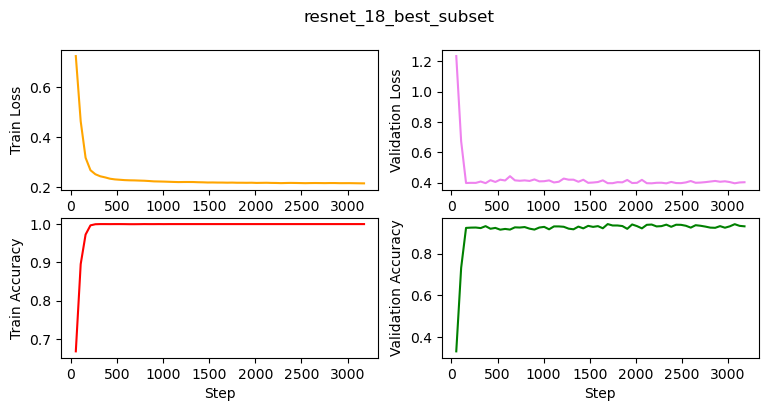

In [28]:
plot_metrics(LOG_PATH+'resnet_18_best_subset',show=True)

In [27]:
for run in input_event_dirs:
    plot_metrics(run)

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>